# Обучение нейросетей — оптимизация и регуляризация

**Разработчик: Артем Бабенко**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aosokin/dl_cshse_ami/blob/master/2021-fall/homeworks_small/shw4/DL21-fall-shw4.ipynb)


На это семинаре будет необходимо 
1. реализовать Dropout-слой и проследить его влияние на обобщающую способность сети 
2. реализовать BatchNormalization-слой и пронаблюдать его влияние на скорость сходимости обучения.

## Dropout

Как всегда будем экспериментировать на датасете MNIST. MNIST является стандартным бенчмарк-датасетом, и его можно подгрузить средствами pytorch.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
input_size = 784
num_classes = 10
batch_size = 128

train_dataset = dsets.MNIST(root='./MNIST/', 
                                   train=True, 
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.MNIST(root='./MNIST/', 
                                  train=False, 
                                  transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

C:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Определим ряд стандартных функций с прошлых семинаров

In [3]:
def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        data = x_batch
        target = y_batch

        optimizer.zero_grad()
        output = model(data)
        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target).cpu()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log    

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):    
        data = x_batch
        target = y_batch

        output = model(data)
        loss = F.nll_loss(output, target).cpu()

        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, batchsize=batch_size)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))
        
        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')   
        
        print("Epoch: {2}, val loss: {0}, val accuracy: {1}".format(np.mean(val_loss), np.mean(val_acc), epoch))


Создайте простейшую однослойную модель - однослойную полносвязную сеть и обучите ее с параметрами оптимизации, заданными ниже.

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)
    
model = nn.Sequential(
    #<your code>
    Flatten(),
    nn.Linear(28 * 28, 10),
    nn.Sigmoid()
    )

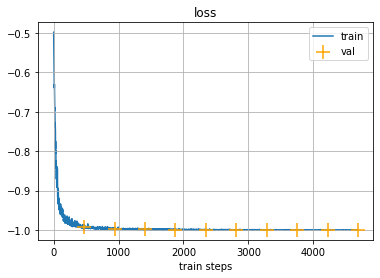

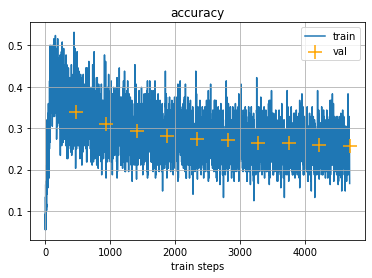

Epoch: 9, val loss: -0.9998583446575117, val accuracy: 0.25662580132484436


In [13]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
train(model, opt, 10)

Параметром обученной нейросети является матрица весов, в которой каждому классу соответствует один из 784-мерных столбцов. Визуализируйте обученные векторы для каждого из классов, сделав их двумерными изображениями 28-28. Для визуализации можно воспользоваться кодом для визуализации MNIST-картинок с предыдущих семинаров.

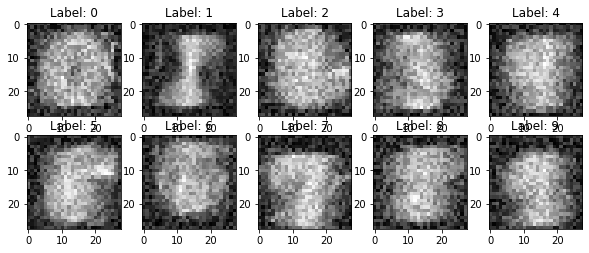

In [32]:
#<your code>
for name, p in model.named_parameters():
    if name == '1.weight':
        weights = p.data
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

Реализуйте Dropout-слой для полносвязной сети. Помните, что этот слой ведет себя по-разному во время обучения и во время применения. 

In [6]:
class DropoutLayer(nn.Module):
    def __init__(self, p):
        super().__init__()
        #<your code>
        self.p = p
        # self.training = True


    def forward(self, input):
        if self.training:
            #<your code>
            mask = torch.bernoulli(torch.tensor([1 - self.p] * input.shape[1])) / (1 - self.p)
            return input * mask
        else:
            #<your code>
            return input

Добавьте Dropout-слой в архитектуру сети, проведите оптимизацию с параметрами, заданными ранее, визуализируйте обученные веса. Есть ли разница между весами обученными с Dropout и без него? Параметр Dropout возьмите равным 0.7

In [11]:
modelDp = nn.Sequential(
    #<your code>
    Flatten(),
    DropoutLayer(0.7),
    nn.Linear(28 * 28, 10),
    nn.Sigmoid()
    )

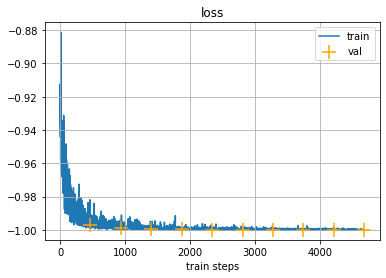

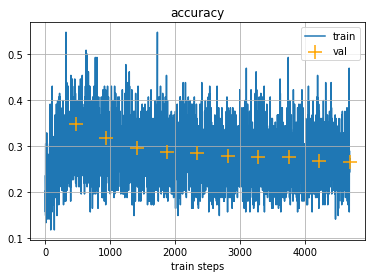

Epoch: 9, val loss: -0.9999498159070558, val accuracy: 0.2652294337749481


In [13]:
opt = torch.optim.Adam(modelDp.parameters(), lr=0.0005)
train(modelDp, opt, 10)

Как видим, дропаут не сильно улучшил качество, но улучшил. Видимо потому что дропаут на входной слой это какая-то муть - просто по сути понижаем качество изображения без какого либо смысла.

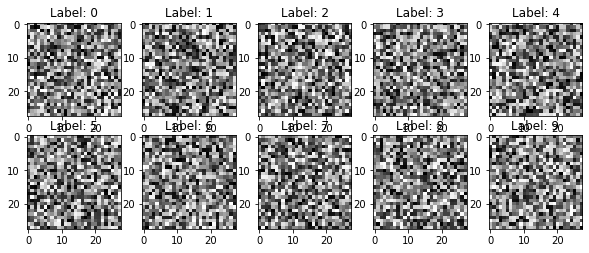

In [15]:
for name, p in model.named_parameters():
    if name == '1.weight':
        weights = p.data
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

Обучите еще одну модель, в которой вместо Dropout-регуляризации используется L2-регуляризация с коэффициентом 0.05. (Параметр weight_decay в оптимизаторе). Визуализируйте веса и сравните с двумя предыдущими подходами.

In [16]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(input_size,num_classes),
    nn.LogSoftmax(dim=-1)
    )

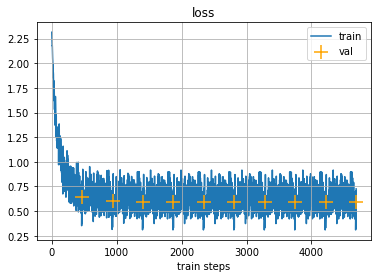

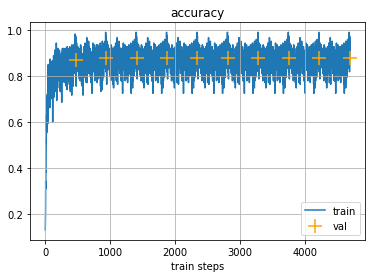

Epoch: 9, val loss: 0.5904797309938865, val accuracy: 0.8812302350997925


In [17]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.05)
train(model, opt, 10)

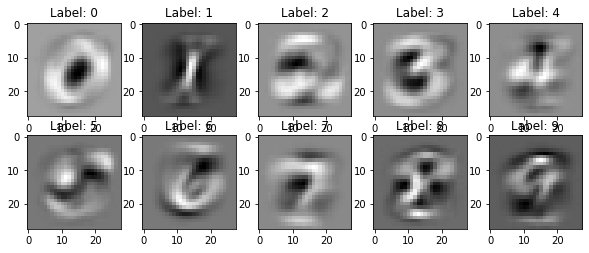

In [18]:
for name, p in model.named_parameters():
    if name == '1.weight':
        weights = p.data
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

## Batch normalization

Реализуйте BatchNormalization слой для полносвязной сети. В реализации достаточно только центрировать и разделить на корень из дисперсии, аффинную поправку (гамма и бета) в этом задании можно не реализовывать.

In [24]:
class BnLayer(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        #<your code>
        self.mean = 0
        self.std = 0
        self.std_list = [0] * num_features
        self.mean_list = [0] * num_features
        self.num_features = num_features

    def forward(self, input):
        eps = 1e-6
        if self.training:
            #<your code>
            mean = torch.mean(input, dim=0)
            self.mean_list.append(mean)
            self.mean += (mean - self.mean_list.pop(0)) / self.num_features
            std = torch.std(input, dim=0, unbiased=False)
            self.std_list.append(std)
            self.std += (std - self.std_list.pop(0)) / self.num_features
            return (input - mean) / (std + eps)
        else:
            #<your code>
            pass
        return (input - self.mean) / (self.std + eps)

Обучите трехслойную полносвязную сеть (размер скрытого слоя возьмите 100) с сигмоидами в качестве функций активации. 

In [25]:
hidden_size = 100
model = nn.Sequential(
    #<your code>
    Flatten(),
    nn.Linear(28 * 28, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, 10),
    nn.Sigmoid(),
    nn.LogSoftmax(dim=-1)
    )

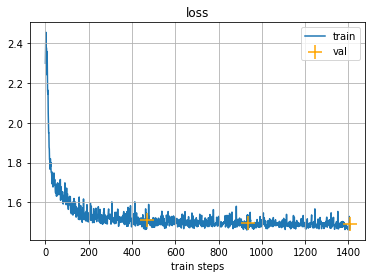

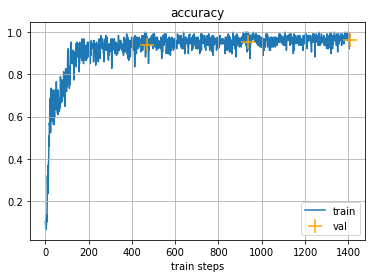

Epoch: 2, val loss: 1.4934418729588956, val accuracy: 0.9611352682113647


In [21]:
opt = torch.optim.RMSprop(model.parameters(), lr=0.01)
train(model, opt, 3)

Повторите обучение с теми же параметрами для сети с той же архитектурой, но с добавлением BatchNorm слоя (для всех трех скрытых слоев).

In [28]:
modelBN = nn.Sequential(
    #<your code>
    Flatten(),
    nn.Linear(28 * 28, hidden_size),
    BnLayer(100),
    nn.Sigmoid(),
    nn.Linear(hidden_size, hidden_size),
    BnLayer(100),
    nn.Sigmoid(),
    nn.Linear(hidden_size, 10),
    BnLayer(100),
    nn.Sigmoid(),
    nn.LogSoftmax(dim=-1)
    )

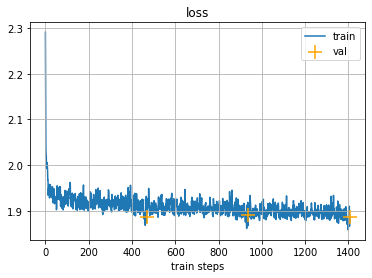

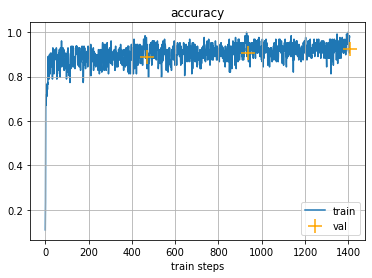

Epoch: 2, val loss: 1.8871427216107333, val accuracy: 0.9238528609275818


In [29]:
opt = torch.optim.RMSprop(modelBN.parameters(), lr=0.01)
train(modelBN, opt, 3)

Сравните кривые обучения и сделайте вывод о влиянии BatchNorm на ход обучения.

Ну видно, что что-то особо отличий нет. Даже во варинте с BN качество заметно хуже. Наверное это связано с тем, что сеть не очень глубокая, а нейронов в слоях много (для таких данных, как у нас). Поэтому BN скорее мешает адекватному обучению (типа эвристика без теоретических обоснований, которая не работает - ну бывает).